# System Identification by Lennart Ljung

In this Jupyter Notebook we will discover the ideas of System Identification. The Notebook is written by following along the book System Identification by Lennart Ljung (1st edition). Here, we will learn the knowledge needed in order to be able to apply system identification in real life. The book will be followed chronologically and Python is utilized to clarify some of the ideas.

# Chapter 1

For starters we want to develop properties between the input to a system and the output of a system. In general, for linear time-invariant and casual systems, where we assume the input is constant over a sampling period T, the output can be fully characterized by its impulse response 

$y(t) = \sum_{k=1}^{\infty}g(k)u(t-k), \quad t = 0,1,2,\dots$

Where we use t to enumerate the sampling instants. Obviously, k does not naturally go to infinity, but is usually finite. Let us discover through an example. Normally we do not know what g(k) is, but for illustration purposes, we can assume a system for now. Let us suppose:

$g(1) = 1 \\ $ 
$g(2) = 2 \\ $
$g(3) = 0 \\ $
$g(4) = 1 \\ $

With this information, we can simulate the system response $y(t)$ for any arbitrary input sequence $u(t)$. 

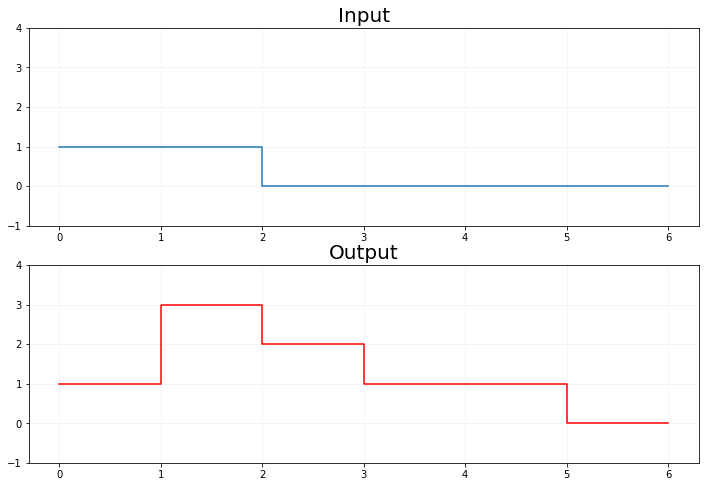

In [93]:
import numpy as np 
import matplotlib.pyplot as plt #for plots
from matplotlib.patches import StepPatch #for stair plots
#from bokeh.layouts import column
#from bokeh.models import ColumnDataSource, Slider, CustomJS
#from bokeh.plotting import figure, output_file, show

g = [1, 2, 0, 1]
u = [1, 1] #change to arbitrary input

def impulse_response(g,u):
    #calculate the impulse response based on definition 
    #page 15 eq. 2.6 
    
    len_g = len(g)
    len_u = len(u)
    
    y = []
    for i in range(len_g+len_u+1):
        y_temp = 0
        for k in range(len_g):
            if (i-k>=0) & (i-k <= len_u-1):
                y_temp += g[k]*u[i-k]
        y.append(y_temp)
    return y

y = impulse_response(g,u) #get response

def MatchLengths(LongVec, InVec):
    #pad InVec with zeros to match length of LongVec for easier plotting.
    
    lenLongVec = len(LongVec)
    shape = np.shape(InVec)
    padded_array = np.zeros((lenLongVec))
    padded_array[0:shape[0]] = InVec
    
    return padded_array

uvec = MatchLengths(y,u) #input padded with zeros
timevec = np.linspace(0,len(y)-1,len(y)) #create sampling instants

fig, axs = plt.subplots(2,1,figsize=(12,8))
axs[0].plot(timevec, uvec, drawstyle='steps-post')
axs[0].set_title('Input',fontsize=20)
axs[1].plot(timevec, y, drawstyle='steps-post',color='red')
axs[1].set_title('Output',fontsize=20)

for ax in axs:
    ax.grid(axis='x',color='0.95')
    ax.grid(axis='y',color='0.95')
    ax.set_ylim([min(min(uvec),min(y))-1, max(max(uvec),max(y))+1]) 
    
#Up next: Create slider to input?
